**R-CNN implimetation**                                                         
In this notebook we will learn to impliment R-CNN network on airplane detection task, using some of the popular deep-learning frameworks.  

**Mounting Gdrive** --
In the below tab we are going to mount our google drive to reach particular directories and load data


Check Tensorflow Version

In [1]:
import tensorflow as tf
tf.__version__

'2.8.0'

Changing Working Directory to Directory where data is stored

We will start by loading in the packages

In [2]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

Run this cell to set the path and annot to the address of your image folder and Airplanes_Annotations folder.

In [3]:
path = "C:/Users/yg058/Desktop/study/DeepLearning/code/Images"
annot = "C:/Users/yg058/Desktop/study/DeepLearning/code/Airplanes_Annotations"

Our airplane dataset contains two parts   
1) Image part-> Contain pictures of airplanes   
2) Airplanes_Annotations-> Contain information about bounding boxes for the pictures available.     
The next cell will show you an example of a labelled image in the dataset. Feel free to change the value of `Index` below and re-run to see different examples.

airplane_147.jpg


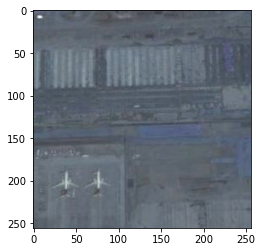

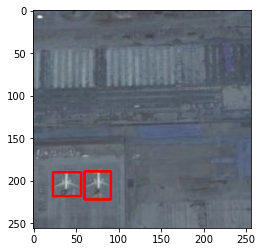

In [4]:
Index=147
filename = "airplane_"+str(Index)+".jpg"
print(filename)
img = cv2.imread(os.path.join(path,filename)) #사진
df = pd.read_csv(os.path.join(annot,filename.replace(".jpg",".csv"))) # 정보
plt.imshow(img)
for row in df.iterrows():
    x1 = int(row[1][0].split(" ")[0])
    y1 = int(row[1][0].split(" ")[1])
    x2 = int(row[1][0].split(" ")[2])
    y2 = int(row[1][0].split(" ")[3])
    cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
plt.figure()
plt.imshow(img)

**Let's start**                   
R-CNN object detection system consists of three modules. The first generates category-independent region proposals(through selective search here). These proposals define the set of candidate detections available to our detector. The second module is a large convolutional neural network that extracts a fixed-length feature
vector from each region(here we use VGG 16 whereas original paper works on AlexNet). The third module is a set of class specific linear SVMs. So, let's implient them step by step.
![alt text](https://miro.medium.com/max/2372/0*Sdj6sKDRQyZpO6oH.)

**Selective search**                                                    
Selective Search is a region proposal algorithm used in object detection. It is designed to be fast with a very high recall. It is based on computing hierarchical grouping of similar regions based on color, texture, size and shape compatibility.

![alt text](https://arthurdouillard.com/figures/selective_search1.png)

To impliment selective search we use cv2 library, to get more insight of it you can follow this [link](https://pypi.org/project/opencv-python/)

In [5]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

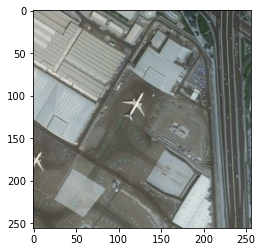

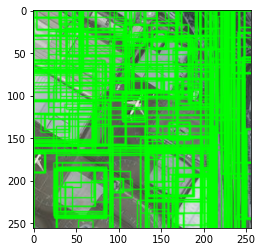

In [6]:
im = cv2.imread(os.path.join(path,"42850.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
plt.imshow(imOut)
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.figure()
plt.imshow(imOut)

Run above cells to get region proposals from selective search algorithm ,performed on a single image to give you more insight of what the algorithm is doing.

**Intersection over union**
Intersection over Union is simply an evaluation metric. Any algorithm that provides predicted bounding boxes as output can be evaluated using IoU.          
More formally, in order to apply Intersection over Union to evaluate an (arbitrary) object detector we need:                                
1.The ground-truth bounding boxes (i.e., the hand labeled bounding boxes from the testing set that specify where in the image our object is).
2.The predicted bounding boxes from our model.   
After getting these two we can find there intersection and union area,whih ultimately gives us our IoU.
![alt text](https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png)

In [7]:
def get_iou(bb1, bb2):
  # assuring for proper dimension.
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
  # calculating dimension of common area between these two boxes.
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
  # if there is no overlap output 0 as intersection area is zero.
    if x_right < x_left or y_bottom < y_top:
        return 0.0
  # calculating intersection area.
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
  # individual areas of both these bounding boxes.
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
  # union area = area of bb1_+ area of bb2 - intersection of bb1 and bb2.
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

**Preparing training data**
Training data here is prepared according to following scheme:-   
a) Those boxes which have an IoU greater than 0.7 (original paper it's 0.5) are considered as a positive example.   
b) And boxes with relative low IoU 0.3 are taken to be negative examples.  
Number of regions taken here is 30 positive and 30 negative (original paper have 32 and 96 respectively) of size 224x224.
Note- Original paper also talk about warping but as we have resized them already so there is no need of it.

In [8]:
# At the end of below code we will have our train data in these lists
train_images=[]
train_labels=[]

In [9]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)   # setting given image as base image
            ss.switchToSelectiveSearchFast()     # running selective search on bae image 
            ssresults = ss.process()     # processing to get the outputs
            imout = image.copy()   
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            #print(ssresults[0])
            for e,result in enumerate(ssresults):
                
                if e < 2000 and flag == 0:     # till 2000 to get top 2000 regions only
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})  # calculating IoU for each of the proposed regions
                        if counter < 30:       # getting only 30 psoitive examples
                            if iou > 0.70:     # IoU or being positive is 0.7
                                timage = imout[x:x+w,y:y+h]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1              # to insure we have collected all psotive examples
                        if falsecounter <30:      # 30 negatve examples are allowed only
                            if iou < 0.3:         # IoU or being negative is 0.3
                                timage = imout[x:x+w,y:y+h]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1             #to ensure we have collected all negative examples
                    if fflag == 1 and bflag == 1:  
                        print("inside")
                        flag = 1        # to signal the complition of data extaction from a particular image
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

17 airplane_001.jpg
inside
18 airplane_002.jpg
19 airplane_003.jpg
20 airplane_004.jpg
inside
21 airplane_005.jpg
inside
22 airplane_006.jpg
23 airplane_007.jpg
inside
24 airplane_008.jpg
25 airplane_009.jpg
26 airplane_010.jpg
27 airplane_011.jpg
28 airplane_012.jpg
inside
29 airplane_013.jpg
30 airplane_014.jpg
31 airplane_015.jpg
32 airplane_016.jpg
33 airplane_017.jpg
34 airplane_018.jpg
35 airplane_019.jpg
36 airplane_020.jpg
37 airplane_021.jpg
38 airplane_022.jpg
39 airplane_023.jpg
40 airplane_024.jpg
41 airplane_025.jpg
42 airplane_026.jpg
43 airplane_027.jpg
44 airplane_028.jpg
45 airplane_029.jpg
46 airplane_030.jpg
47 airplane_031.jpg
48 airplane_032.jpg
49 airplane_033.jpg
50 airplane_034.jpg
51 airplane_035.jpg
52 airplane_036.jpg
53 airplane_037.jpg
54 airplane_038.jpg
55 airplane_039.jpg
56 airplane_040.jpg
57 airplane_041.jpg
inside
58 airplane_042.jpg
59 airplane_043.jpg
60 airplane_044.jpg
61 airplane_045.jpg
inside
62 airplane_046.jpg
63 airplane_047.jpg
64 airplane

In [10]:
# conversion of train data into arrays for further training
X_new = np.array(train_images)
Y_new = np.array(train_labels)

**Load packages**  
let's load the requied packages

In [11]:
from keras.layers import Dense
from keras import Model
from keras import optimizers

**Pre-training**  
We perform tansfer-learning as pre-training here as we are using VGG16 net which is already trained on Imagenet.  We are going to train a binary classifier by making all layers as untrainble except two last.    And then we are going to make a new model which will be stacked on last 2nd output layer.


In [12]:
vgg = tf.keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
for layer in vgg.layers[:-2]:
  layer.trainable = False
x = vgg.get_layer('fc2')
last_output =  x.output
x = tf.keras.layers.Dense(1,activation = 'sigmoid')(last_output)  
model = tf.keras.Model(vgg.input,x)
model.compile(optimizer = "adam", 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])



**Summary of the model and Training**

In [13]:
model.summary()
model.fit(X_new,Y_new,batch_size = 16,epochs = 3, verbose = 1,validation_split=.05,shuffle = True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

NotFoundError: Graph execution error:

Detected at node 'model/block1_conv2/Conv2D' defined at (most recent call last):
    File "c:\ProgramData\Anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\ProgramData\Anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "c:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "c:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "c:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "c:\ProgramData\Anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\yg058\AppData\Local\Temp/ipykernel_7364/1689212434.py", line 2, in <module>
      model.fit(X_new,Y_new,batch_size = 16,epochs = 3, verbose = 1,validation_split=.05,shuffle = True)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\layers\convolutional.py", line 248, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "c:\ProgramData\Anaconda3\lib\site-packages\keras\layers\convolutional.py", line 233, in convolution_op
      return tf.nn.convolution(
Node: 'model/block1_conv2/Conv2D'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 222445584 bytes.
  Profiling failure on CUDNN engine 1: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 17226880 bytes.
  Profiling failure on CUDNN engine 0#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 2#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1866465280 bytes.
  Profiling failure on CUDNN engine 2: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1866465280 bytes.
  Profiling failure on CUDNN engine 4#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2722250752 bytes.
  Profiling failure on CUDNN engine 4: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2722250752 bytes.
  Profiling failure on CUDNN engine 6#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 17188096 bytes.
  Profiling failure on CUDNN engine 6: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 17188096 bytes.
  Profiling failure on CUDNN engine 5#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 52428800 bytes.
  Profiling failure on CUDNN engine 5: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 52428800 bytes.
  Profiling failure on CUDNN engine 7#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 942211072 bytes.
  Profiling failure on CUDNN engine 7: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 942211072 bytes.
	 [[{{node model/block1_conv2/Conv2D}}]] [Op:__inference_train_function_1483]

**Making New Network with svm**

We will start with first creating the dataset for the svm and will then go for the architecture

In [ ]:
svm_image = [];
svm_label = [];

**SVM Dataset**    
For svm dataset we considered all ground truth bounding boxes as positive examples and those which were having an IOU less than 0.3 as false examples to increase the preciseness.

In [ ]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3]) 
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
                timage = image[x1:x2,y1:y2]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                svm_image.append(resized)
                svm_label.append([0,1])
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if falsecounter <5:
                            if iou < 0.3:
                                timage = imout[x:x+w,y:y+h]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                svm_image.append(resized)
                                svm_label.append([1,0])
                                falsecounter += 1
                        else :
                            flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

**SVM Model Architecture**  
First we removed the last layer of the previous model and then added a Dense layer of 2 units at the end.

Now we will see our new Model Summary and we will train it.

/content/drive/My Drive/AI content/RCNN-master


In [ ]:
#adding svm to last layer
x =model.get_layer('fc2').output
Y = tf.keras.layers.Dense(2)(x)
final_model = tf.keras.Model(model.input,Y)
final_model.compile(loss='hinge',
              optimizer='adam',
              metrics=['accuracy'])
final_model.summary()
final_model.load_weights('my_model_weights.h5')

In [ ]:
hist_final = final_model.fit(np.array(svm_image),np.array(svm_label),batch_size=32,epochs = 20,verbose = 1,shuffle = True,validation_split = 0.05)

**Ploting  loss and analysing losses**

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist_final.history['loss'])
plt.plot(hist_final.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

**Test Time**  
By Running the below cell we can get the bounding boxes of a particular image and can cherish ourselves.

In [ ]:
###########  it's time for test a image    ##########
image = cv2.imread(os.path.join(path,'airplane_020.jpg'))
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()

imOut = image.copy()
boxes = []
count = 0
for e,result in enumerate(ssresults):
  if e < 50:
    x,y,w,h = result
    timage = imout[x:x+w,y:y+h]
    resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
    resized = np.expand_dims(resized,axis = 0)
    out = final_model.predict(resized)
    print(e,out)
    if(out[0][0]<out[0][1]):
      boxes.append([x,y,w,h])
      count+=1

for box in boxes:
    x, y, w, h = box
    print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)